## Word count analysis over time

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pandas as pd
import os
from scipy.stats import pearsonr, spearmanr


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import CHAPTERS_DATA_TSV

In [35]:
def count_words(s: str):
    return len(s.split())

In [36]:
def words_per_second(row: pd.Series) -> float | None:
    n_words = row["word_count"]
    duration_s = row["duration_sec"]

    if pd.notna(duration_s) or pd.notna(n_words):
        return n_words / duration_s
    else:
        return None


def get_duration_sec(row: pd.Series) -> float | None:
    start_ms = row["start"]
    end_ms = row["end"]

    if pd.notna(start_ms) or pd.notna(end_ms):
        duration_sec = (float(end_ms) - float(start_ms)) / 1000
        return duration_sec
    else:
        return None

In [37]:
# Load chapters
tsv_file = Path(CHAPTERS_DATA_TSV).resolve()
df = pd.read_csv(tsv_file, sep="\t")

# Filter data

# Only data with timestamps
df = df[(df["start"].notna()) & (df["end"].notna())]

In [38]:
DF_COMBAT = df[(df["is_combat_scene"].notna()) & (df["is_combat_scene"])]
DF_WAR_REPORT = df[(df["is_war_report"].notna()) & (df["is_war_report"])]
DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]

/tmp/ipykernel_195493/1091624069.py:3: Pandas4Warning: 'and' operations between boolean dtype and str are deprecated and will raise in a future version. Explicitly cast the strings to a boolean dtype before operating instead.
  DF_SOLDIERS = df[(df["german_soldiers_depicted"].notna()) & (df["german_soldiers_depicted"])]


In [39]:
df = DF_COMBAT

print(f"Data size: {len(df)}")

df["word_count"] = df["audio_transcription"].apply(count_words)
df["duration_sec"] = df.apply(lambda row: get_duration_sec(row), axis=1)
df["word_count_per_second"] = df.apply(lambda row: words_per_second(row), axis=1)

Data size: 875


In [40]:
df["word_count_per_second"].describe()

count    875.000000
mean       0.933355
std        0.484840
min        0.121739
25%        0.611663
50%        0.801587
75%        1.116883
max        3.428571
Name: word_count_per_second, dtype: float64

In [41]:
df["word_count_per_minute"] = df["word_count_per_second"]*60

In [42]:
episode_median = (
    df
    .groupby(['episode', "year"], as_index=False)
    ['word_count_per_minute']
    .median()
)
episode_median

,episode,year,word_count_per_minute
0,511,1940,58.123667
1,512,1940,51.502146
2,513,1940,81.600000
3,514,1940,35.736677
4,515,1940,29.912023
...,...,...,...
212,750,1945,82.886957
213,751,1945,105.000000
214,753,1945,123.157895
215,754,1945,111.428571


In [43]:
x = df['episode']
y = df['word_count_per_minute']

pearson_r, pearson_p = pearsonr(x, y)
spearman_r, spearman_p = spearmanr(x, y)

pearson_r, pearson_p, spearman_r, spearman_p


(np.float64(0.29021512778771663),
 np.float64(1.923936850162554e-18),
 np.float64(0.3016272419260197),
 np.float64(7.320295368369785e-20))

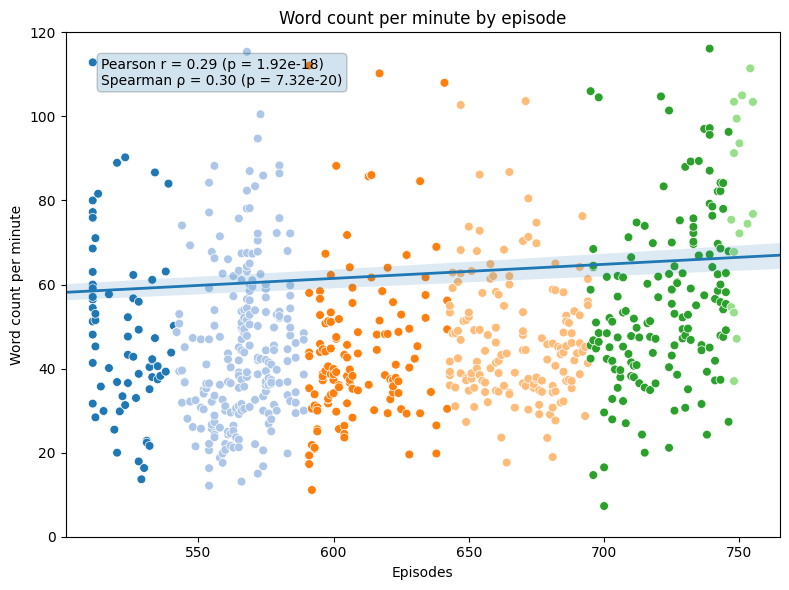

In [44]:
df_sorted = df.sort_values(['episode', "chapter"]).reset_index(drop=True)


text = (
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3g})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3g})"
)

plt.figure(figsize=(8, 6))

# sns.lineplot(
#     data=df_sorted,
#     x="episode",
#     y='word_count_per_minute',
#     linewidth=0,
#     alpha=0.7
# )

sns.scatterplot(
    data=df_sorted,
    x="episode",
    y='word_count_per_minute',
    hue='year',
    palette='tab20',
    legend=False,
    s=40
)

# LOWESS trendline
sns.regplot(
    x=df_sorted.index,
    y=df_sorted['word_count_per_minute'],
    scatter=False,
    line_kws={'linewidth': 2}
)

plt.text(
    0.05, 0.95,
    text,
    transform=plt.gca().transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.2)
)

plt.xlim(min(df['episode'])-10, max(df['episode'])+10)
plt.ylim(0, 120)
plt.xlabel("Episodes")
plt.ylabel("Word count per minute")
plt.title("Word count per minute by episode")

plt.tight_layout()
plt.show()
